## Naive Bayes Classifier - Text Classification - Multinomial & Bernoulli

In this notebook you will apply the Naive Bayes algorithms for text classification.

Your tasks are marked with task numbers (e.g., Task 1). To get full credit you need to complete **ALL** tasks.



### Dataset: The 20 Newsgroups data set


The 20 newsgroups dataset comprises around 20,000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering. The split between the train and test set is based upon a messages posted before and after a specific date.

Following is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc


You will normalize the documents, perform preprocessing and vectorize the features. Since the features are categorical, you will implement two different naive Bayes classifiers using Scikit-Learn. 
- Categorical features (binary valued) are modeled using the Multivariate Bernoulli distrubition 
- Categorical features (multi-valued) are modeled using the Multinomial distrubition 


## Steps for Classification:

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization (Stemming & Lemmatization)
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features
3. Model Selection by Hyperparameter Tuning
4. Train the Optimal Model
5. Analyzing Model Performance
6. Evaluate the Model on Test Data

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.datasets import fetch_20newsgroups

[nltk_data] Downloading package wordnet to /Users/jian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data

You will work on a partial dataset with only 4 categories out of the 20 available in the dataset:
- alt.atheism
- soc.religion.christian
- comp.graphics
- sci.med


The samples are shuffled randomly. This is useful if you wish to select only a subset of samples to quickly train a model and get a first idea of the results before re-training on the complete dataset later.

## Create Train and Test Sets 

In [5]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
X_train = train_data.data
y_train = train_data.target


test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
X_test = test_data.data
y_test = test_data.target

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

In [6]:
print("Target Names: ", train_data.target_names)

print("\nNumber of Training Examples: ", len(X_train))
print("Number of Training Labels: ", len(y_train))

print("Number of Test Examples: ",len(X_test))
print("Number of Test Labels: ", len(y_test))


print("\nPrint a Random Document:\n")
print(X_train[0])

Target Names:  ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

Number of Training Examples:  2257
Number of Training Labels:  2257
Number of Test Examples:  1502
Number of Test Labels:  1502

Print a Random Document:

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



## Class Distribution

#### Task 1: Compute class distribution in the following block (5 pts)

In [7]:
train_cat_vals = []
print("Train data distribution:\n")
for i in range(len(categories)):
    print("%s: %d" %(categories[i], sum(y_train==i)))
    train_cat_vals.append(sum(y_train==i))
print("\nTest data distribution:\n")
for i in range(len(categories)):
    print("%s: %d" %(categories[i], sum(y_test==i)))

Train data distribution:

alt.atheism: 480
soc.religion.christian: 584
comp.graphics: 594
sci.med: 599

Test data distribution:

alt.atheism: 319
soc.religion.christian: 389
comp.graphics: 396
sci.med: 398


## Visualization of the Class Distribution


#### Task 2: Generate visualization of the class distribution in the following block (5 pts)

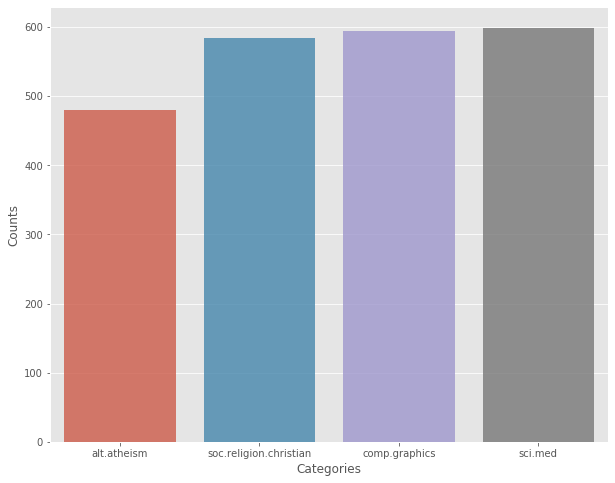

In [8]:
plt.figure(figsize=(10,8))
sns.barplot(categories, train_cat_vals, alpha=0.8)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

# <font color=blue> 2. Feature Extraction </font>

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.


#### Task 3: Lemmatize the training data. You may stem it as well, if it improves the classification accuracy. (10 pts)

In [9]:
%%time
lemmatizer = WordNetLemmatizer()
X_train_lemmatized = []
X_test_lemmatized = []
for i in range(len(X_train)):
    train_lower = nltk.word_tokenize(X_train[i].lower())
    X_train_lemmatized.append(' '.join(lemmatizer.lemmatize(w) for w in train_lower))
for i in range(len(X_test)):
    test_lower = nltk.word_tokenize(X_test[i].lower())
    X_test_lemmatized.append(' '.join(lemmatizer.lemmatize(q) for q in test_lower))
print(train_lower)

['from', ':', 'dyer', '@', 'spdcc.com', '(', 'steve', 'dyer', ')', 'subject', ':', 're', ':', 'is', 'msg', 'sensitivity', 'superstition', '?', 'organization', ':', 's.p', '.', 'dyer', 'computer', 'consulting', ',', 'cambridge', 'ma', 'lines', ':', '14', 'in', 'article', '<', '1qnns0', '$', '4l3', '@', 'agate.berkeley.edu', '>', 'spp', '@', 'zabriskie.berkeley.edu', '(', 'steve', 'pope', ')', 'writes', ':', '>', 'the', 'mass', 'of', 'anectdotal', 'evidence', ',', 'combined', 'with', 'the', 'lack', 'of', '>', 'a', 'properly', 'constructed', 'scientific', 'experiment', 'disproving', '>', 'the', 'hypothesis', ',', 'makes', 'the', 'msg', 'reaction', 'hypothesis', 'the', '>', 'most', 'likely', 'explanation', 'for', 'events', '.', 'you', 'forgot', 'the', 'smiley-face', '.', 'i', 'ca', "n't", 'believe', 'this', 'is', 'what', 'they', 'turn', 'out', 'at', 'berkeley', '.', 'tell', 'me', 'you', "'re", 'an', 'aberration', '.', '--', 'steve', 'dyer', 'dyer', '@', 'ursa-major.spdcc.com', 'aka', '{', 

In [7]:
#X_train_lemmatized_df = pd.DataFrame(X_train_lemmatized)
#y_train_df = pd.DataFrame(y_train)
print(X_train[0])
print('\nLemmatized Sample:\n')
print(X_train_lemmatized[0])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.


Lemmatized Sample:

from : sd345 @ city.ac.uk ( michael collier ) subject : converting image to hp laserjet iii ? nntp-posting-host : hampton organization : the city university line : 14 doe anyone know of a good way ( standard pc application/pd utility ) to convert tif/img/tga file into laserjet iii format . w

# <font color=blue> 2. Feature Extraction </font>

## b) Text Preprocessing & c) Feature Vectorization

We can combine text preprocessing, feature vectorization and model training using the sklearn Pipeline object. This Pipeline object can be used for model selection and for training the optimal model. 

## <font color=blue> 3. Model Selection </font>


There are no hyperparameters in a NB model except the Laplace smoothing parameter alpha.

However, there are multiple hyperparameters for the CountVectorizer() and TfidfTransformer(). We need to select the best model based on the optimal values of these hyperparameters. This process is called hyper-parameter tuning.

For hyperparameter tuning, we will build a compund classifier using the sklearn Pipeline class. It will combine the CountVectorizer(), TfidfTransformer() and MultinomialNB() objects and will create a single object.

## Building a Pipeline for Hyperparameter Tuning


#### Task 4: Build a Pipeline object by combining CountVectorizer() and MultinomialNB() (5 pts)

In [8]:
text_clf_multinomial = Pipeline([('vect', CountVectorizer()), 
                                 ('clf', MultinomialNB())])

## Hyperparameter Tuning

#### Task 5: Perform hyperparamer tuning for the following hyperparameters: (5 pts)
- CountVectorizer()
         -- ngram_range
         -- stop_words
- MultinomialNB()
        -- alpha
        
## **<font color=red size=5>Important:</font>**

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

The macro-average ("f1_macro") will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average ("f1_micro") will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In the binary classification, "f1" score function can be used. We may also use the precision_score, recall_score, roc_auc_score functions.

In [9]:
%%time
param_grid = {'vect__ngram_range': [(1,1), (1,2)],
             'vect__stop_words': ['english', None],
             'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5, 2.0]}

clf_multinomial_cv = GridSearchCV(text_clf_multinomial, param_grid,
                                 scoring='f1_macro', cv=5, verbose=1,
                                 n_jobs=-1)

clf_multinomial_cv = clf_multinomial_cv.fit(X_train_lemmatized, y_train)

params_optimal_clf_multinomial = clf_multinomial_cv.best_params_


print("\nBest Score: %f" %clf_multinomial_cv.best_score_)

print("\nOptimal Hyperparameter Values: ")
for param_name in sorted(param_grid.keys()):
    print('%s: %r' %(param_name, params_optimal_clf_multinomial[param_name]))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   36.7s finished



Best Score: 0.981470

Optimal Hyperparameter Values: 
clf__alpha: 0.001
vect__ngram_range: (1, 2)
vect__stop_words: 'english'
CPU times: user 4.48 s, sys: 687 ms, total: 5.17 s
Wall time: 38.2 s


# <font color=blue> 4. Train the Optimal Multinomial Model </font>

#### Task 6: Using the optimal hyperparameter values, create the optimal model. Then, fit the model. (10 pts)
- Build a Pipeline object by combining CountVectorizer() and MultinomialNB()

In [10]:
multinomial_clf = Pipeline([('vect', CountVectorizer(stop_words='english',
                                                    ngram_range=(1,2),
                                                    binary=False)), 
                            ('clf', MultinomialNB(alpha=0.001))
                           ])

multinomial_clf.fit(X_train_lemmatized, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))],
         verbose=False)

# <font color=blue> 6. Evaluate the Model on Test Data </font>

#### Task 7:  Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report


### Note: For multi-class classification, set the "average" attribute to "micro" for the following functions:
- precision_score
- recall_score
- f1_score

In [11]:
y_test_pred = multinomial_clf.predict(X_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision_test = precision_score(y_test, y_test_pred, average='macro')
print("\nTest Precision: %f" %precision_test)

recall_test = recall_score(y_test, y_test_pred, average='macro')
print("\nTest Recall: %f" %recall_test)

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nTest F1 Score: %f" %f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=categories))


Test Confusion Matrix:
[[299   4   4  12]
 [  6 371  10   2]
 [  3  24 356  13]
 [  5   5   4 384]]

Test Precision: 0.939942

Test Recall: 0.938711

Test F1 Score: 0.938971

Classification Report:
                        precision    recall  f1-score   support

           alt.atheism       0.96      0.94      0.95       319
soc.religion.christian       0.92      0.95      0.94       389
         comp.graphics       0.95      0.90      0.92       396
               sci.med       0.93      0.96      0.95       398

              accuracy                           0.94      1502
             macro avg       0.94      0.94      0.94      1502
          weighted avg       0.94      0.94      0.94      1502



#  Multinomial NB: TF-IDF Model

#### Task 8: Implement the Multinomial model using the TF-IDF feature vectors (10 pts)
- Build a Pipeline object by combining CountVectorizer(), TfidfTransformer() and MultinomialNB()

In [12]:
multinomial_clf_tfidf = Pipeline([('vect', 
                                   CountVectorizer(stop_words='english',
                                  ngram_range=(1,2), binary=False)), 
                                  ('tfidf', TfidfTransformer()),
                                  ('clf', MultinomialNB(alpha=0.001))
                                 ])

multinomial_clf_tfidf.fit(X_train_lemmatized, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))],
         verbose=False)

## Evaluate the Model on Test Data 

#### Task 9: Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [13]:
y_test_pred_tfidf = multinomial_clf_tfidf.predict(X_test_lemmatized)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_tfidf))

precision_test_tfidf = precision_score(y_test, y_test_pred_tfidf, average='macro')
print("\nTest Precision: %f" %precision_test_tfidf)

recall_test_tfidf = recall_score(y_test, y_test_pred_tfidf, average='macro')
print("\nTest Recall: %f" %recall_test_tfidf)

f1_test_tfidf = f1_score(y_test, y_test_pred_tfidf, average='macro')
print("\nTest F1 Score: %f" %f1_test_tfidf)


print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_tfidf))


Test Confusion Matrix:
[[290   4   7  18]
 [  6 368  11   4]
 [  3  22 356  15]
 [  5   2   6 385]]

Test Precision: 0.933101

Test Recall: 0.930358

Test F1 Score: 0.931277

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       319
           1       0.93      0.95      0.94       389
           2       0.94      0.90      0.92       396
           3       0.91      0.97      0.94       398

    accuracy                           0.93      1502
   macro avg       0.93      0.93      0.93      1502
weighted avg       0.93      0.93      0.93      1502



## <font color=maroon> Observation on Multinomial Model With TF-IDF Feature Vectors </font>

We observe that both precision and recall decrease with TF-IDF feature vectors. 

#  Multivariate Bernoulli NB

#### Task 10: Implement the Multivariate Bernoulli Model (10 pts)
- Build a Pipeline object by combining CountVectorizer() and BernoulliNB()

### <font color=red> Note: </font>
The "binary" attribute of the CountVectorizer() object should be set to "True".

In [14]:
%%time
clf_bernoulli = Pipeline([('vect', CountVectorizer(binary=True)), 
                            ('clf', BernoulliNB())
                           ])


param_grid = {'vect__ngram_range': [(1,1), (1,2)],
             'vect__stop_words': ['english', None],
             'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5, 2.0]
             }

clf_bernoulli_cv = GridSearchCV(clf_bernoulli, param_grid, scoring='f1_macro',
                               cv=5, verbose=1, n_jobs=-1)

clf_bernoulli_cv = clf_bernoulli_cv.fit(X_train_lemmatized, y_train)

params_optimal_clf_bernoulli = clf_bernoulli_cv.best_params_

print('\nBest Score: %f' %clf_bernoulli_cv.best_score_)
print('\nOptimal Parameters:\n')

for param_name in sorted(param_grid.keys()):
    print('%s: %r' %(param_name, params_optimal_clf_bernoulli[param_name]))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   37.9s finished



Best Score: 0.973774

Optimal Parameters:

clf__alpha: 0.0001
vect__ngram_range: (1, 1)
vect__stop_words: 'english'
CPU times: user 3.7 s, sys: 559 ms, total: 4.26 s
Wall time: 38.4 s


In [15]:
#model best parameters
bernoulli_clf = Pipeline([('vect', CountVectorizer(stop_words='english', 
                          ngram_range=(1,1),
                          binary=True)), 
                          ('clf', BernoulliNB(alpha=0.0001))]
                        )
bernoulli_clf.fit(X_train_lemmatized, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 BernoulliNB(alpha=0.0001, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

## Evaluate the Model on Test Data 


#### Task 11: Evaluate the model on test data and generate (10 pts)
- Confusion Matrix
- Precision
- Recall
- F1 score
- Classification Report

In [16]:
y_test_pred_bernoulli = bernoulli_clf.predict(X_test_lemmatized)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_bernoulli))

precision_test_bernoulli = precision_score(y_test, y_test_pred_bernoulli, average='macro')
print("\nTest Precision: %f" %precision_test_bernoulli)

recall_test_bernoulli = recall_score(y_test, y_test_pred_bernoulli, average='macro')
print("\nTest Recall: %f" %recall_test_bernoulli)

f1_test_bernoulli = f1_score(y_test, y_test_pred_bernoulli, average='macro')
print("\nTest F1 Score: %f" %f1_test_bernoulli)

classification_report_test_bernoulli = classification_report(y_test, y_test_pred_bernoulli)
print("\nClassification Report:", classification_report_test_bernoulli)


Test Confusion Matrix:
[[286   7   8  18]
 [  3 373  11   2]
 [  2  33 357   4]
 [  5  11   7 375]]

Test Precision: 0.929474

Test Recall: 0.924787

Test F1 Score: 0.926315

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.90      0.93       319
           1       0.88      0.96      0.92       389
           2       0.93      0.90      0.92       396
           3       0.94      0.94      0.94       398

    accuracy                           0.93      1502
   macro avg       0.93      0.92      0.93      1502
weighted avg       0.93      0.93      0.93      1502



## <font color=maroon> Observation on Multivariate Bernoulli Model </font>

#### Task 12: Write a short account of your observation on the following aspects of your experimentation with 3 NB classifiers (10 pts):
- Impact of data normalization technique (did you observe performance improvement with lemmatization and/or stemming)
- Which classifier gave the best precision? Best recall? Best F1 Score? Explain their performance variance.


<font size=4, color=navy> - Yes, there is a improvement with lemmatization. Lemmatization saves a lof of space and ignores many unnecessary tabs and thus improves correctness of classification.</font>
<pre></pre>
<font size=4, color=navy> - The multinomial Naive Bayes classifier gave the best precision, recall and f1 score. multinomial gave all the best scores, and multinomial with TF-IDF ranks second, the bernoulli NB classifier gave the lowest score. Since the text occurrance matters so multinomial performs better on classification than bernoulli classifier.</font>